In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import partial 
import seaborn as sns
import random
import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import RidgeCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import xgboost
from xgboost import XGBClassifier, XGBRegressor, plot_importance
import catboost
from catboost import CatBoostClassifier,CatBoostRegressor, Pool, metrics, cv


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.inspection import plot_partial_dependence

In [2]:
data= pd.read_csv("/Users/baeknarim/2022_1/데이터마이닝/팀플/data/total4_사고건수별_사망자수추가변수.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371925 entries, 0 to 371924
Data columns (total 43 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   지점명            371925 non-null  object 
 1   일시             371925 non-null  object 
 2   발생년            371925 non-null  int64  
 3   발생일            371925 non-null  int64  
 4   발생시간           371925 non-null  object 
 5   발생분            371925 non-null  object 
 6   주야             371925 non-null  object 
 7   요일             371925 non-null  object 
 8   사망자수           371925 non-null  int64  
 9   사상자수           371925 non-null  int64  
 10  중상자수           371925 non-null  int64  
 11  경상자수           371925 non-null  int64  
 12  부상신고자수         371925 non-null  int64  
 13  도로종류           371925 non-null  object 
 14  노면상태_대분류       371925 non-null  object 
 15  노면상태           371925 non-null  object 
 16  기상상태           371925 non-null  object 
 17  사고유형_대분류       371925 non-nul

In [3]:
#"일시","발생일","발생분" 변수 삭제
#data=data.drop(["일시","발생일","발생분",'노면상태_대분류','사고유형_대분류','사고유형_중분류','가해자_법규위반_대분류',
#               '도로형태_대분류','가채자_당사종별_대분류','피해자_당사자종별_대분류'],axis=1)

data=data.drop(["일시","발생일","발생분"],axis=1)

# Xgboost

In [4]:
#x(categorical) - onehot encoding
data2 = pd.get_dummies(data)
data2.head()

,발생년,사망자수,사상자수,중상자수,경상자수,부상신고자수,기온..C.,강수량.mm.,풍속.m.s.,풍향.16방위.,...,피해자_당사자종별_승용차,피해자_당사자종별_승합차,피해자_당사자종별_없음,피해자_당사자종별_열차,피해자_당사자종별_원동기장치자전거,피해자_당사자종별_이륜차,피해자_당사자종별_자전거,피해자_당사자종별_중형,피해자_당사자종별_특수차,피해자_당사자종별_화물차
0,2015,0,1,1,0,0,-7.4,0.0,6.1,290.0,...,0,0,0,0,0,0,0,0,0,0
1,2015,0,1,1,0,0,-7.4,0.0,6.1,290.0,...,0,0,0,0,0,0,0,0,0,0
2,2015,0,1,1,0,0,-7.4,0.0,6.1,290.0,...,0,0,0,0,0,0,0,0,0,0
3,2015,0,1,0,1,0,-7.4,0.0,6.1,290.0,...,0,0,0,0,0,0,0,1,0,0
4,2015,0,1,1,0,0,-0.5,0.0,3.8,320.0,...,0,0,0,0,0,0,0,0,0,0


# y : 사망자수_binary - 층화추출

In [6]:
#y : 사망자수_binary - 층화추출
#train, test 나누기 
#data_x = data2.drop(["사망자수","중상자수","사상자수","경상자수","부상신고자수","사망자수_binary","사망자수_3class"], axis=1)
#data_y = data2["사망자수_binary"]


#train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size = 0.2, 
#                                                    random_state = 1234, stratify=data_y) # 
#print(train_x.shape, test_x.shape, train_y.shape, test_y.shape) # 데이터 개수 확인

(297540, 228) (74385, 228) (297540,) (74385,)


In [5]:
#train: 2015 2016 2017 /test: 2018

train = data2[data2["발생년"]<2018]
test = data2[data2["발생년"]==2018]

test.head()

,발생년,사망자수,사상자수,중상자수,경상자수,부상신고자수,기온..C.,강수량.mm.,풍속.m.s.,풍향.16방위.,...,피해자_당사자종별_승용차,피해자_당사자종별_승합차,피해자_당사자종별_없음,피해자_당사자종별_열차,피해자_당사자종별_원동기장치자전거,피해자_당사자종별_이륜차,피해자_당사자종별_자전거,피해자_당사자종별_중형,피해자_당사자종별_특수차,피해자_당사자종별_화물차
281357,2018,0,2,0,2,0,-3.2,0.0,0.5,110.0,...,1,0,0,0,0,0,0,0,0,0
281358,2018,0,2,1,1,0,-3.2,0.0,0.5,110.0,...,0,0,0,0,0,0,0,0,0,1
281359,2018,0,1,0,1,0,-3.2,0.0,0.5,110.0,...,0,0,0,0,0,0,0,0,0,0
281360,2018,0,1,1,0,0,-3.2,0.0,0.5,110.0,...,0,0,0,0,0,0,0,0,0,0
281361,2018,0,1,0,1,0,0.8,0.0,3.3,290.0,...,1,0,0,0,0,0,0,0,0,0


In [6]:

train_x = train.drop(["사망자수","중상자수","사상자수","경상자수","부상신고자수","사망자수_binary","사망자수_3class"], axis=1)
train_y = train["사망자수_binary"]

test_x = test.drop(["사망자수","중상자수","사상자수","경상자수","부상신고자수","사망자수_binary","사망자수_3class"], axis=1)
test_y = test["사망자수_binary"]

print(train_x.shape, test_x.shape, train_y.shape, test_y.shape) # 데이터 개수 확인

(281357, 228) (90568, 228) (281357,) (90568,)


In [8]:
print(train_y[train_y==1].sum())
print(test_y[test_y==1].sum())

3148
894


In [9]:
##################################cv#################################
start= time.time() 
xgb = XGBClassifier()

xgb_grid={
    'max_depth':[2,4,6], 
    'colsample_bytree':[0.6,0.8],
    'gamma':[0.1,0.5,1],
    'min_child_weight':[0.5,1],
    'n_estimators':[500,1000],
    'learning_rate':[0.05,0.1], 
    'random_state':[1234]
}

xgbCV=GridSearchCV(xgb, xgb_grid, verbose=2) 
xgbCV.fit(train_x, train_y)
print("실행시간 :{}".format(time.time()-start)) 
print(xgbCV.best_params_)


Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=2, min_child_weight=0.5, n_estimators=500, random_state=1234; total time=  46.8s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=2, min_child_weight=0.5, n_estimators=500, random_state=1234; total time=  46.3s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=2, min_child_weight=0.5, n_estimators=500, random_state=1234; total time=  47.3s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=2, min_child_weight=0.5, n_estimators=500, random_state=1234; total time=  46.7s


KeyboardInterrupt: 

In [10]:
#modeling 
start=time.time()

xgb_cl=xgboost.XGBClassifier(random_state=1234)
xgb_cl.fit(train_x,train_y) 
print("실행시간:[]".format(time.time()-start))

pred_y = xgb_cl.predict(test_x) 
report=classification_report(test_y, pred_y) 
print(report)

con_mat=confusion_matrix(pred_y, test_y) 
print(con_mat)

실행시간:[]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     89674
           1       0.46      0.03      0.05       894

    accuracy                           0.99     90568
   macro avg       0.73      0.51      0.52     90568
weighted avg       0.99      0.99      0.99     90568

[[89647   871]
 [   27    23]]


Text(0.5, 1.0, 'Feature importance')

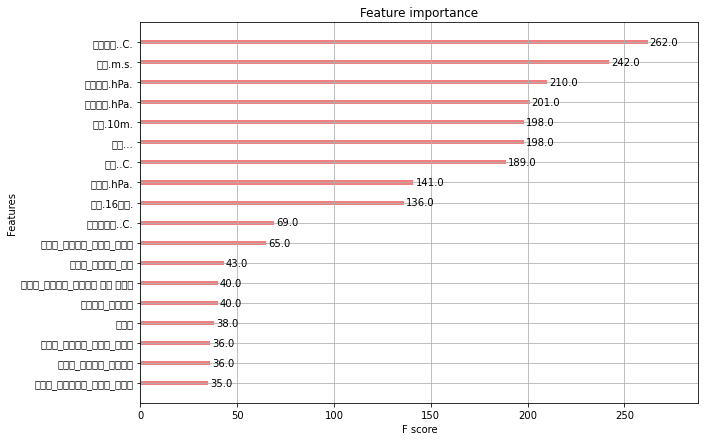

In [11]:
#feature importance
fig, ax=plt.subplots(1,1,figsize=(10,7))
plot_importance(xgb_cl, ax=ax, color="lightcoral", max_num_features=18) 
plt.title("Feature importance")


In [ ]:
#pdp
plot_partial_dependence(xgb_cl, features=[],X=train_x)

# y : 사망자수_3class - 층화추출

In [14]:
#train, test 나누기 
#data_x = data2.drop(["사망자수","중상자수","사상자수","경상자수","부상신고자수","사망자수_binary","사망자수_3class"], axis=1)
#data_y = data2["사망자수_3class"]


#train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size = 0.2, 
#                                                    random_state = 1234, stratify=data_y) # 
#print(train_x.shape, test_x.shape, train_y.shape, test_y.shape) # 데이터 개수 확인

(297540, 228) (74385, 228) (297540,) (74385,)


In [12]:
#train: 2015 2016 2017 /test: 2018

train = data2[data2["발생년"]<2018]
test = data2[data2["발생년"]==2018]

test.head()

,발생년,사망자수,사상자수,중상자수,경상자수,부상신고자수,기온..C.,강수량.mm.,풍속.m.s.,풍향.16방위.,...,피해자_당사자종별_승용차,피해자_당사자종별_승합차,피해자_당사자종별_없음,피해자_당사자종별_열차,피해자_당사자종별_원동기장치자전거,피해자_당사자종별_이륜차,피해자_당사자종별_자전거,피해자_당사자종별_중형,피해자_당사자종별_특수차,피해자_당사자종별_화물차
281357,2018,0,2,0,2,0,-3.2,0.0,0.5,110.0,...,1,0,0,0,0,0,0,0,0,0
281358,2018,0,2,1,1,0,-3.2,0.0,0.5,110.0,...,0,0,0,0,0,0,0,0,0,1
281359,2018,0,1,0,1,0,-3.2,0.0,0.5,110.0,...,0,0,0,0,0,0,0,0,0,0
281360,2018,0,1,1,0,0,-3.2,0.0,0.5,110.0,...,0,0,0,0,0,0,0,0,0,0
281361,2018,0,1,0,1,0,0.8,0.0,3.3,290.0,...,1,0,0,0,0,0,0,0,0,0


In [13]:

train_x = train.drop(["사망자수","중상자수","사상자수","경상자수","부상신고자수","사망자수_binary","사망자수_3class"], axis=1)
train_y = train["사망자수_3class"]

test_x = test.drop(["사망자수","중상자수","사상자수","경상자수","부상신고자수","사망자수_binary","사망자수_3class"], axis=1)
test_y = test["사망자수_3class"]

print(train_x.shape, test_x.shape, train_y.shape, test_y.shape) # 데이터 개수 확인

(281357, 228) (90568, 228) (281357,) (90568,)


In [14]:
print(train_y[train_y==1].sum())
print(test_y[test_y==1].sum())

3138
893


In [17]:
print(train_y[train_y==2].sum())
print(test_y[test_y==2].sum())

20
2


In [ ]:
#################################cv#################################
start= time.time() 
xgb = XGBClassifier()

xgb_grid={
    'max_depth':[2,4,6], 
    'colsample_bytree':[0.6,0.8],
    'gamma':[0.1,0.5,1],
    'min_child_weight':[0.5,1],
    'n_estimators':[500,1000],
    'learning_rate':[0.05,0.1], 
    'random_state':[1234]
}

xgbCV=GridSearchCV(xgb, xgb_grid, verbose=2) 
xgbCV.fit(train_x, train_y)
print("실행시간 :{}".format(time.time()-start)) 
print(xgbCV.best_params_)



In [15]:
#modeling 
start=time.time()
xgb_cl=xgboost.XGBClassifier(random_state=1234)
xgb_cl.fit(train_x,train_y) 
print("실행시간:[]".format(time.time()-start))

pred_y = xgb_cl.predict(test_x) 
report=classification_report(test_y, pred_y) 
print(report)

con_mat=confusion_matrix(pred_y, test_y) 
print(con_mat)

실행시간:[]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     89674
           1       0.54      0.03      0.06       893
           2       0.00      0.00      0.00         1

    accuracy                           0.99     90568
   macro avg       0.51      0.34      0.35     90568
weighted avg       0.99      0.99      0.99     90568

[[89649   864     1]
 [   25    29     0]
 [    0     0     0]]


Text(0.5, 1.0, 'Feature importance')

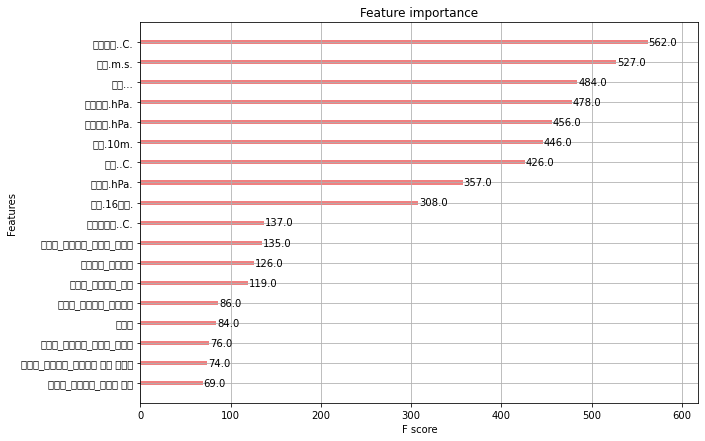

In [16]:
#feature importance
fig, ax=plt.subplots(1,1,figsize=(10,7))
plot_importance(xgb_cl, ax=ax, color="lightcoral", max_num_features=18) 
plt.title("Feature importance")



In [ ]:
#pdp
plot_partial_dependence(xgb_cl, features=[],X=train_x)

# Catboost

In [34]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371925 entries, 0 to 371924
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   지점명            371925 non-null  category
 1   발생년            371925 non-null  int64   
 2   발생시간           371925 non-null  category
 3   주야             371925 non-null  category
 4   요일             371925 non-null  category
 5   사망자수           371925 non-null  int64   
 6   사상자수           371925 non-null  int64   
 7   중상자수           371925 non-null  int64   
 8   경상자수           371925 non-null  int64   
 9   부상신고자수         371925 non-null  int64   
 10  도로종류           371925 non-null  category
 11  노면상태_대분류       371925 non-null  object  
 12  노면상태           371925 non-null  category
 13  기상상태           371925 non-null  category
 14  사고유형_대분류       371925 non-null  object  
 15  사고유형_중분류       371925 non-null  object  
 16  사고유형           371925 non-null  category
 17  가해자_법규위반_대

In [19]:
data.head()

,지점명,발생년,발생시간,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,...,증기압.hPa.,이슬점온도..C.,현지기압.hPa.,해면기압.hPa.,적설.cm.,X3시간신적설.cm.,시정.10m.,지면온도..C.,사망자수_binary,사망자수_3class
0,서울,2015,00시,야,목,0,1,1,0,0,...,1.2,-20.9,1011.8,1023.0,0.0,0.0,2000.0,-4.5,0,0
1,서울,2015,00시,야,목,0,1,1,0,0,...,1.2,-20.9,1011.8,1023.0,0.0,0.0,2000.0,-4.5,0,0
2,서울,2015,00시,야,목,0,1,1,0,0,...,1.2,-20.9,1011.8,1023.0,0.0,0.0,2000.0,-4.5,0,0
3,서울,2015,00시,야,목,0,1,0,1,0,...,1.2,-20.9,1011.8,1023.0,0.0,0.0,2000.0,-4.5,0,0
4,부산,2015,00시,야,목,0,1,1,0,0,...,2.5,-11.8,1009.6,1018.4,0.0,0.0,2000.0,-1.3,0,0


In [35]:
data["지점명"]=data["지점명"].astype('category')
data["발생시간"]=data["발생시간"].astype('category')
data["주야"]=data["주야"].astype('category')
data["요일"]=data["요일"].astype('category')
data["도로종류"]=data["도로종류"].astype('category')
data["노면상태"]=data["노면상태"].astype('category')
data["기상상태"]=data["기상상태"].astype('category')
data["사고유형"]=data["사고유형"].astype('category')
data["가해자_법규위반"]=data["가해자_법규위반"].astype('category')
data["도로형태"]=data["도로형태"].astype('category')
data["가해자_당사자종별"]=data["가해자_당사자종별"].astype('category')
data["피해자_당사자종별"]=data["피해자_당사자종별"].astype('category')

data["노면상태_대분류"]=data["노면상태_대분류"].astype('category')
data["사고유형_대분류"]=data["사고유형_대분류"].astype('category')
data["사고유형_중분류"]=data["사고유형_중분류"].astype('category')
data["가해자_법규위반_대분류"]=data["가해자_법규위반_대분류"].astype('category')
data["도로형태_대분류"]=data["도로형태_대분류"].astype('category')
data["가채자_당사종별_대분류"]=data["가채자_당사종별_대분류"].astype('category')
data["피해자_당사자종별_대분류"]=data["피해자_당사자종별_대분류"].astype('category')


data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371925 entries, 0 to 371924
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   지점명            371925 non-null  category
 1   발생년            371925 non-null  int64   
 2   발생시간           371925 non-null  category
 3   주야             371925 non-null  category
 4   요일             371925 non-null  category
 5   사망자수           371925 non-null  int64   
 6   사상자수           371925 non-null  int64   
 7   중상자수           371925 non-null  int64   
 8   경상자수           371925 non-null  int64   
 9   부상신고자수         371925 non-null  int64   
 10  도로종류           371925 non-null  category
 11  노면상태_대분류       371925 non-null  category
 12  노면상태           371925 non-null  category
 13  기상상태           371925 non-null  category
 14  사고유형_대분류       371925 non-null  category
 15  사고유형_중분류       371925 non-null  category
 16  사고유형           371925 non-null  category
 17  가해자_법규위반_대

# y : 사망자수_binary

In [36]:
#y : 사망자수_binary - 층화추출
#train, test 나누기 

#data_x = data.drop(["사망자수","중상자수","사상자수","경상자수","부상신고자수","사망자수_binary","사망자수_3class"], axis=1)
#data_y = data["사망자수_binary"]


#train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size = 0.2, 
#                                                    random_state = 1234, stratify=data_y) # 
#print(train_x.shape, test_x.shape, train_y.shape, test_y.shape) # 데이터 개수 확인

In [37]:
#train: 2015 2016 2017 /test: 2018

train = data[data["발생년"]<2018]
test = data[data["발생년"]==2018]

test.head()

,지점명,발생년,발생시간,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,...,증기압.hPa.,이슬점온도..C.,현지기압.hPa.,해면기압.hPa.,적설.cm.,X3시간신적설.cm.,시정.10m.,지면온도..C.,사망자수_binary,사망자수_3class
281357,서울,2018,00시,야,월,0,2,0,2,0,...,1.9,-14.9,1015.4,1026.4,0.0,0.0,1358.0,-2.2,0,0
281358,서울,2018,00시,야,월,0,2,1,1,0,...,1.9,-14.9,1015.4,1026.4,0.0,0.0,1358.0,-2.2,0,0
281359,서울,2018,00시,야,월,0,1,0,1,0,...,1.9,-14.9,1015.4,1026.4,0.0,0.0,1358.0,-2.2,0,0
281360,서울,2018,00시,야,월,0,1,1,0,0,...,1.9,-14.9,1015.4,1026.4,0.0,0.0,1358.0,-2.2,0,0
281361,대구,2018,00시,야,월,0,1,0,1,0,...,2.4,-12.2,1018.1,1024.9,0.0,0.0,2000.0,-1.3,0,0


In [38]:

train_x = train.drop(["사망자수","중상자수","사상자수","경상자수","부상신고자수","사망자수_binary","사망자수_3class"], axis=1)
train_y = train["사망자수_binary"]

test_x = test.drop(["사망자수","중상자수","사상자수","경상자수","부상신고자수","사망자수_binary","사망자수_3class"], axis=1)
test_y = test["사망자수_binary"]

print(train_x.shape, test_x.shape, train_y.shape, test_y.shape) # 데이터 개수 확인

(281357, 33) (90568, 33) (281357,) (90568,)


In [39]:
print(train_y[train_y==1].sum())
print(test_y[test_y==1].sum())


3148
894


In [40]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281357 entries, 0 to 281356
Data columns (total 33 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   지점명            281357 non-null  category
 1   발생년            281357 non-null  int64   
 2   발생시간           281357 non-null  category
 3   주야             281357 non-null  category
 4   요일             281357 non-null  category
 5   도로종류           281357 non-null  category
 6   노면상태_대분류       281357 non-null  category
 7   노면상태           281357 non-null  category
 8   기상상태           281357 non-null  category
 9   사고유형_대분류       281357 non-null  category
 10  사고유형_중분류       281357 non-null  category
 11  사고유형           281357 non-null  category
 12  가해자_법규위반_대분류   281357 non-null  category
 13  가해자_법규위반       281357 non-null  category
 14  도로형태_대분류       281357 non-null  category
 15  도로형태           281357 non-null  category
 16  가채자_당사종별_대분류   281357 non-null  category
 17  가해자_당사자종별 

In [41]:
#cols names
cat_cols = train_x.columns[train_x.dtypes=='category'].to_list() 
num_cols = train_x.columns[train_x.dtypes!='category'].to_list() 
cat_cols


['지점명',
 '발생시간',
 '주야',
 '요일',
 '도로종류',
 '노면상태_대분류',
 '노면상태',
 '기상상태',
 '사고유형_대분류',
 '사고유형_중분류',
 '사고유형',
 '가해자_법규위반_대분류',
 '가해자_법규위반',
 '도로형태_대분류',
 '도로형태',
 '가채자_당사종별_대분류',
 '가해자_당사자종별',
 '피해자_당사자종별_대분류',
 '피해자_당사자종별']

In [ ]:
##################################cv#################################
#grid search
start=time.time() 
clr=catboost.CatBoostClassifier(loss_function="Logloss",boosting_type="Ordered",cat_features=cat_cols)

clr_grid={
    'max_depth':[2,4,6], 
    'border_count':[64,254], 
    'rsm' :[0.5,0.85], 
    'l2_leaf_reg':[0.1,0.5,1], 
    'n_estimators':[500,1000], 
    'learning_rate':[0.05,0.1], 
    'random_state':[1234]
}
clrCV=GridSearchCV(clr, clr_grid, verbose=2) clrCV.fit(train_x, train_y)
print("실행시간 :{}".format(time.time()-start)) print(clrCV.best_params_)



In [42]:
#modeling

start=time.time() 
clr_cl=catboost.CatBoostClassifier(random_state= 1234)
clr_cl.fit(train_x,train_y, verbose=True, cat_features=cat_cols)
print("실행시간:[]".format(time.time()-start))


pred_y = clr_cl.predict(test_x) 
report=classification_report(test_y, pred_y) 
print(report)

con_mat=confusion_matrix(pred_y, test_y) 
print(con_mat)

Learning rate set to 0.11449
0:	learn: 0.4743091	total: 256ms	remaining: 4m 15s
1:	learn: 0.3315233	total: 435ms	remaining: 3m 37s
2:	learn: 0.2408539	total: 626ms	remaining: 3m 28s
3:	learn: 0.1820583	total: 785ms	remaining: 3m 15s
4:	learn: 0.1439701	total: 942ms	remaining: 3m 7s
5:	learn: 0.1187095	total: 1.08s	remaining: 2m 59s
6:	learn: 0.1017280	total: 1.26s	remaining: 2m 59s
7:	learn: 0.0901146	total: 1.45s	remaining: 2m 59s
8:	learn: 0.0805142	total: 1.6s	remaining: 2m 55s
9:	learn: 0.0748912	total: 1.71s	remaining: 2m 49s
10:	learn: 0.0701145	total: 1.86s	remaining: 2m 47s
11:	learn: 0.0674882	total: 1.91s	remaining: 2m 37s
12:	learn: 0.0646282	total: 2.04s	remaining: 2m 34s
13:	learn: 0.0624524	total: 2.18s	remaining: 2m 33s
14:	learn: 0.0606594	total: 2.33s	remaining: 2m 32s
15:	learn: 0.0592967	total: 2.48s	remaining: 2m 32s
16:	learn: 0.0580338	total: 2.64s	remaining: 2m 32s
17:	learn: 0.0569516	total: 2.8s	remaining: 2m 32s
18:	learn: 0.0562872	total: 2.96s	remaining: 2m 

Text(0.5, 1.0, 'Feature importance')

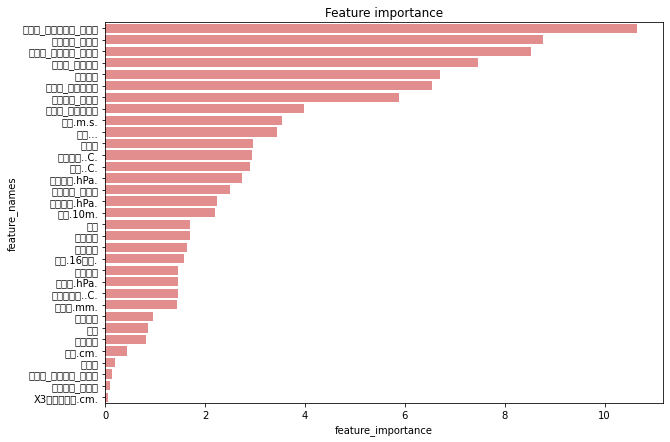

In [43]:
fig, ax=plt.subplots(1,1,figsize=(10,7))
temp = pd.DataFrame({'feature_importance':clr_cl.get_feature_importance(),
'feature_names':train_x.columns}).sort_values(by=["feature_importance"], ascending=False)
sns.barplot(x="feature_importance", y="feature_names", data=temp, color="lightcoral")
plt.title("Feature importance")

# y : 사망자수_3class

In [54]:
#y : 사망자수_binary - 층화추출
#train, test 나누기 
#data_x = data.drop(["사망자수","중상자수","사상자수","경상자수","부상신고자수","사망자수_binary","사망자수_3class"], axis=1)
#data_y = data["사망자수_3class"]


#train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size = 0.2, 
#                                                    random_state = 1234, stratify=data_y) # 
#print(train_x.shape, test_x.shape, train_y.shape, test_y.shape) # 데이터 개수 확인

(297540, 26) (74385, 26) (297540,) (74385,)


In [44]:
#train: 2015 2016 2017 /test: 2018

train = data[data["발생년"]<2018]
test = data[data["발생년"]==2018]

test.head()

,지점명,발생년,발생시간,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,...,증기압.hPa.,이슬점온도..C.,현지기압.hPa.,해면기압.hPa.,적설.cm.,X3시간신적설.cm.,시정.10m.,지면온도..C.,사망자수_binary,사망자수_3class
281357,서울,2018,00시,야,월,0,2,0,2,0,...,1.9,-14.9,1015.4,1026.4,0.0,0.0,1358.0,-2.2,0,0
281358,서울,2018,00시,야,월,0,2,1,1,0,...,1.9,-14.9,1015.4,1026.4,0.0,0.0,1358.0,-2.2,0,0
281359,서울,2018,00시,야,월,0,1,0,1,0,...,1.9,-14.9,1015.4,1026.4,0.0,0.0,1358.0,-2.2,0,0
281360,서울,2018,00시,야,월,0,1,1,0,0,...,1.9,-14.9,1015.4,1026.4,0.0,0.0,1358.0,-2.2,0,0
281361,대구,2018,00시,야,월,0,1,0,1,0,...,2.4,-12.2,1018.1,1024.9,0.0,0.0,2000.0,-1.3,0,0


In [45]:

train_x = train.drop(["사망자수","중상자수","사상자수","경상자수","부상신고자수","사망자수_binary","사망자수_3class"], axis=1)
train_y = train["사망자수_3class"]

test_x = test.drop(["사망자수","중상자수","사상자수","경상자수","부상신고자수","사망자수_binary","사망자수_3class"], axis=1)
test_y = test["사망자수_3class"]

print(train_x.shape, test_x.shape, train_y.shape, test_y.shape) 

(281357, 33) (90568, 33) (281357,) (90568,)


In [46]:
print(train_y[train_y==1].sum())
print(test_y[test_y==1].sum())
print(train_y[train_y==2].sum())
print(test_y[test_y==2].sum())

3138
893
20
2


In [47]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281357 entries, 0 to 281356
Data columns (total 33 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   지점명            281357 non-null  category
 1   발생년            281357 non-null  int64   
 2   발생시간           281357 non-null  category
 3   주야             281357 non-null  category
 4   요일             281357 non-null  category
 5   도로종류           281357 non-null  category
 6   노면상태_대분류       281357 non-null  category
 7   노면상태           281357 non-null  category
 8   기상상태           281357 non-null  category
 9   사고유형_대분류       281357 non-null  category
 10  사고유형_중분류       281357 non-null  category
 11  사고유형           281357 non-null  category
 12  가해자_법규위반_대분류   281357 non-null  category
 13  가해자_법규위반       281357 non-null  category
 14  도로형태_대분류       281357 non-null  category
 15  도로형태           281357 non-null  category
 16  가채자_당사종별_대분류   281357 non-null  category
 17  가해자_당사자종별 

In [48]:
#cols names
cat_cols = train_x.columns[train_x.dtypes=='category'].to_list() 
num_cols = train_x.columns[train_x.dtypes!='category'].to_list() 
cat_cols



['지점명',
 '발생시간',
 '주야',
 '요일',
 '도로종류',
 '노면상태_대분류',
 '노면상태',
 '기상상태',
 '사고유형_대분류',
 '사고유형_중분류',
 '사고유형',
 '가해자_법규위반_대분류',
 '가해자_법규위반',
 '도로형태_대분류',
 '도로형태',
 '가채자_당사종별_대분류',
 '가해자_당사자종별',
 '피해자_당사자종별_대분류',
 '피해자_당사자종별']

In [ ]:
##################################cv#################################
#grid search
start=time.time() 
clr=catboost.CatBoostClassifier(loss_function="Logloss",boosting_type="Ordered",cat_features=cat_cols)

clr_grid={
    'max_depth':[2,4,6], 
    'border_count':[64,254], 
    'rsm' :[0.5,0.85], 
    'l2_leaf_reg':[0.1,0.5,1], 
    'n_estimators':[500,1000], 
    'learning_rate':[0.05,0.1], 
    'random_state':[1234]
}
clrCV=GridSearchCV(clr, clr_grid, verbose=2) clrCV.fit(train_x, train_y)
print("실행시간 :{}".format(time.time()-start)) print(clrCV.best_params_)




In [49]:
#modeling

start=time.time() 
clr_cl=catboost.CatBoostClassifier(random_state= 1234)
clr_cl.fit(train_x,train_y, verbose=True, cat_features=cat_cols)
print("실행시간:[]".format(time.time()-start))


pred_y = clr_cl.predict(test_x) 
report=classification_report(test_y, pred_y) 
print(report)

con_mat=confusion_matrix(pred_y, test_y) 
print(con_mat)

Learning rate set to 0.105496
0:	learn: 0.9057660	total: 487ms	remaining: 8m 6s
1:	learn: 0.7650042	total: 1.13s	remaining: 9m 25s
2:	learn: 0.6562988	total: 1.77s	remaining: 9m 50s
3:	learn: 0.5694951	total: 2.46s	remaining: 10m 13s
4:	learn: 0.4985526	total: 3.14s	remaining: 10m 24s
5:	learn: 0.4396245	total: 3.74s	remaining: 10m 18s
6:	learn: 0.3900216	total: 4.37s	remaining: 10m 20s
7:	learn: 0.3479005	total: 4.97s	remaining: 10m 16s
8:	learn: 0.3118285	total: 5.55s	remaining: 10m 11s
9:	learn: 0.2807748	total: 6.13s	remaining: 10m 6s
10:	learn: 0.2538754	total: 6.44s	remaining: 9m 39s
11:	learn: 0.2305238	total: 6.96s	remaining: 9m 33s
12:	learn: 0.2101615	total: 7.59s	remaining: 9m 36s
13:	learn: 0.1923679	total: 8.18s	remaining: 9m 35s
14:	learn: 0.1767660	total: 8.81s	remaining: 9m 38s
15:	learn: 0.1630883	total: 9.36s	remaining: 9m 35s
16:	learn: 0.1509451	total: 9.94s	remaining: 9m 34s
17:	learn: 0.1402034	total: 10.5s	remaining: 9m 31s
18:	learn: 0.1307497	total: 11.1s	remai

Text(0.5, 1.0, 'Feature importance')

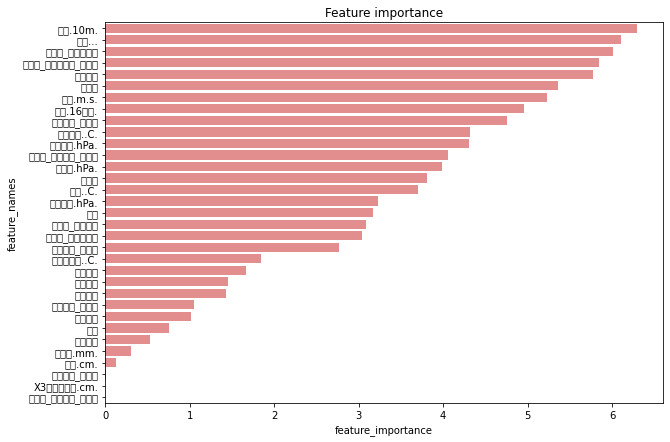

In [50]:
#feature importance
fig, ax=plt.subplots(1,1,figsize=(10,7))
temp = pd.DataFrame({'feature_importance':clr_cl.get_feature_importance(),
'feature_names':train_x.columns}).sort_values(by=["feature_importance"], ascending=False)
sns.barplot(x="feature_importance", y="feature_names", data=temp, color="lightcoral")
plt.title("Feature importance")
